# Predictive Modeling for Beginners

In this tutorial, we will walk through the basics of predictive modeling and provide example code along the way.

### Table of Contents

1. What is predictive modeling?
2. The Learning Machine
3. Training / Validation / Test Split
4. The Predict Function
5. The Correct Classification Rate (CCR) Function

### 1. Predictive Modeling

In the past 15 years, hospitals have begun warehousing patient data, and large medical datasets are now available. The outcome (e.g., diagnosis, or death) for each patient is recorded. Other information about the patient that may be available includes demographic information, the medications prescribed to the patient, various physiological  measurements such as core body temperature and the heart rate, and the procedures ordered for the patient.

We can use predictive modeling to build *models* that predict the outcomes for new patients by generalizing from existing data. That is because patients with similar demographics, physiological measurements, medical histories etc. are likely to have similar outcomes.

A model uses a number of *predictor variables*. The predictor variables can be used to predict the *outcome variable*.

Predictive modeling is a powerful tool that can be applied to a vast number of sectors. For example, businesses can use predictive modeling to analyze customer behavior data and predict how, for example, customers will react to a price change. Predictive models can be used to predict stock prices by using past stock market data. Political scientists use predictive modeling to predict the outcome of a new election in a country based on the current political and economic situation by using datasets that contain past electoral outcomes and the political and economic history of the country.

Predictive models are almost never 100% accurate: they merely generalize patterns in the dataset to predict the most likely outcome for new situations.

#### Overview 

First, we'll discuss how to use what we call a *Learning Machine* to build a model. We will focus on predicting patient outcomes in the Intensive Care Unit (ICU). We'll show  how to generate three important subsets of our dataset: the *training set*, the *validation set*, and the *test set*. We'll then see how our `predict` function can predict the outcomes for new situations -- we will predict whether patients that the Learning Machine hasn't seen before will survive in the ICU. We'll then assess the model's performance by computing the *correct classification rate* (CCR) of the model.

### 2. The Learning Machine

<img src="LearningMachine.png" width="600">

We will perform predictive modeling using the Learning Machine (LM). The Learning Machine is an abstraction. We introduce it here to simplify the presentation.  Think of the LM as a function that takes in a dataset (which contains predictor variables as well as the outcomes for historical data) and produces a model that can predict the outcomes for new situations. The field of Machine Learning deals with building better LMs. Logistic Regression and Neural Networks are examples of LMs.

Data is fed into the LM. The LM learns patterns from the data and spits out a model that the LM deems to be the best way of capturing the relationships in the data. 

Let's focus on predicting in-hospital patient deaths in the ICU. The data was collected in the ICU of the Beth Israel Deaconess Medical Center in Boston. We provide the data in `ICU_data.csv`. The dataset contains demographic and physiological variables that were collected for each patient during their stay in the ICU. 

For more information on the dataset, check [this webpage](https://physionet.org/content/challenge-2012/1.0.0/). 

Let's now get to the code. You will need the following libraries. We recommend installing the [Anaconda](https://www.anaconda.com/distribution/) Python distribution, which comes with all the packages that you need.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import learningmachine as lm

import warnings
warnings.filterwarnings('ignore')

The following is part of the set-up process.

In [2]:
np.random.seed(0)

We will read in `ICU_data.csv` into Python (note that you can open `ICU_data.csv` in spreadsheet software such as Excel, or even with a text editor).

When reading in the data, we will use the `Pandas` package. However, we will mostly not use `Pandas` in this tutorial: we will convert the data to a list-of-lists format almost right away.

In [3]:
df = pd.read_csv("ICU_data.csv", index_col=0)

We can display the first several rows of the dataset as follows. (Open the dataset in Excel or a text editor to confirm that the data was read in correctly.)

In [4]:
df.head()

,Age,DiasABP,FiO2,GCS,Gender,HR,Height,K,MAP,NIDiasABP,...,SysABP,Temp,Urine,Weight,pH,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
1,42.0,59.543420,0.792857,15.000000,M,118.239130,169.787227,3.625000,81.055075,79.000000,...,118.591225,37.658333,89.729730,138.100000,7.43250,10.00000,5.0,7.0,351.063772,0.0
5,77.0,46.101449,0.454545,5.956522,M,79.269231,169.787227,4.333333,72.217391,55.296296,...,132.913043,36.466667,134.017937,111.592208,7.46875,14.96168,9.0,11.0,10.000000,1.0
6,60.0,57.753623,0.549199,13.333333,M,91.652174,175.300000,4.050000,77.985507,58.260870,...,99.014493,37.634694,290.625000,85.772059,7.39800,12.00000,0.0,6.0,351.063772,0.0
8,83.0,60.528090,0.496429,11.533333,F,79.078652,169.787227,4.400000,86.505618,69.666667,...,132.280899,36.716667,113.829787,63.000000,7.33750,18.00000,7.0,10.0,88.000000,0.0
16,59.0,76.250000,0.607143,9.454545,M,63.200000,169.787227,4.150000,106.093023,61.833333,...,150.045455,37.066667,91.714286,91.000000,7.34800,16.00000,9.0,6.0,351.063772,0.0


We have read in a table. The table is stored in a data structure called a dataframe. (But you only need to understand lists of lists to proceed with this tutorial.)

Each row of the dataframe represents data for a single patient. Variables like `Age`, `Gender`, `HR`, `Height`, `PaCO2`, `PaO2`, `Temp`, and `Weight` are called *features*. We will use them as predictors. The very last column is called `In-hospital_death`, which indicates whether the patient survived (0) or died (1) in the ICU.

While `Age`, `Gender`, `Height`, and `Weight` are self-explanatory demographic variables, the others are physiological measurements whose averages (from multiple measurements across time during the patients' stay in the ICU) have been recorded in the dataset. `Temp` is the body temperature, `HR` is the heart rate, `PaCO2` is the [partial pressure of arterial $CO_2$](https://en.wikipedia.org/wiki/PCO2), and `PaO2` is the [partial pressure of arterial $O_2$](https://en.wikipedia.org/wiki/Blood_gas_tension). 

We can see why these features could be important in predicting patient well-being. For example, decreasing body temperature [has been found](https://www.sciencedirect.com/science/article/abs/pii/S1071916408000675?via%3Dihub) to predict early rehospitalization for patients with congestive heart failure. 

Gender is shown as 'M' for male and 'F' for female, but we would like for all variables to be numerical. You can use our function `label_encode` saved in `learningmachine.py` to do this. Understanding the inner workings of the functions in this file is not required for the tutorial. Recall that we imported `learningmachine` as `lm` previously, so in order to retrieve relevant functions, we use the `lm.function` notation.

In [5]:
lm.label_encode(df, 'Gender')
df.head()

,Age,DiasABP,FiO2,GCS,Gender,HR,Height,K,MAP,NIDiasABP,...,SysABP,Temp,Urine,Weight,pH,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
1,42.0,59.543420,0.792857,15.000000,1,118.239130,169.787227,3.625000,81.055075,79.000000,...,118.591225,37.658333,89.729730,138.100000,7.43250,10.00000,5.0,7.0,351.063772,0.0
5,77.0,46.101449,0.454545,5.956522,1,79.269231,169.787227,4.333333,72.217391,55.296296,...,132.913043,36.466667,134.017937,111.592208,7.46875,14.96168,9.0,11.0,10.000000,1.0
6,60.0,57.753623,0.549199,13.333333,1,91.652174,175.300000,4.050000,77.985507,58.260870,...,99.014493,37.634694,290.625000,85.772059,7.39800,12.00000,0.0,6.0,351.063772,0.0
8,83.0,60.528090,0.496429,11.533333,0,79.078652,169.787227,4.400000,86.505618,69.666667,...,132.280899,36.716667,113.829787,63.000000,7.33750,18.00000,7.0,10.0,88.000000,0.0
16,59.0,76.250000,0.607143,9.454545,1,63.200000,169.787227,4.150000,106.093023,61.833333,...,150.045455,37.066667,91.714286,91.000000,7.34800,16.00000,9.0,6.0,351.063772,0.0


`'M'` has been encoded as 1 and `'F'` has been encoded as 0.

From this point on, we will work with our data in the form of a list of lists, instead of as a dataframe. We will use a function called `df_to_lists`, which converts a dataframe to a list of lists. (Again, no need to understand the inner workings.)

We now convert our data into a list of lists.

In [6]:
ICU_data = lm.df_to_list(df)

Let's see what the first list (representing data for the first patient) within our data looks like.

In [7]:
ICU_data[10]

[77.0,
 54.2,
 0.6714285714285714,
 12.470588235294118,
 0.0,
 98.94202898550724,
 152.4,
 3.875,
 73.4,
 45.46153846153846,
 144.75,
 33.666666666666664,
 116.0,
 167.0,
 140851.0,
 105.13333333333334,
 36.57272727272728,
 98.14634146341464,
 59.5,
 7.36,
 14.0,
 3.0,
 6.0,
 3.0,
 1.0]

This is the data for the eleventh patient in the dataset (check to see that it's true!)

In order for us to easily work with our new list, we'll use a function named `columnname_to_index` that displays the indices in our list that the column names in the original table correspond to. 


(Note to students: you don't need to understand the inner workings, but you do need to understand the structure that the function returns.)

We'll now run this function on our table and store the output in `index_predictors_list`. 

In [8]:
index_feature_list = lm.columnname_to_index(df)
index_feature_list

[(0, 'Age'),
 (1, 'DiasABP'),
 (2, 'FiO2'),
 (3, 'GCS'),
 (4, 'Gender'),
 (5, 'HR'),
 (6, 'Height'),
 (7, 'K'),
 (8, 'MAP'),
 (9, 'NIDiasABP'),
 (10, 'Na'),
 (11, 'PaCO2'),
 (12, 'PaO2'),
 (13, 'Platelets'),
 (14, 'RecordID'),
 (15, 'SysABP'),
 (16, 'Temp'),
 (17, 'Urine'),
 (18, 'Weight'),
 (19, 'pH'),
 (20, 'SAPS-I'),
 (21, 'SOFA'),
 (22, 'Length_of_stay'),
 (23, 'Survival'),
 (24, 'In-hospital_death')]

From the list above, we can see that the feature 'Temp' is at index 16 within our list. Let's check it out for the eleventh patient.

In [9]:
ICU_data[10][16]

36.57272727272728

In order to make our code more readable and so that we don't have to look back at our `index_feature_list` to figure out the index at which a certain feature is located, we'll use another function named `feature_ind` that returns the index that corresponds to the feature name. 

In [10]:
def feature_ind(feat_name):
    """
    Take feature name and return relevant index within list.
    """
    for row in index_feature_list:
        if feat_name == row[1]:
            return row[0]

Let's make sure 'Temp' corresponds to index 16 as we saw above.

In [11]:
feature_ind('Temp')

16

Now we'll use this function to find the eleventh patient's 'Temp'. 

In [12]:
ICU_data[10][feature_ind('Temp')]

36.57272727272728

Let's visualize the relationship between `Age` and `HR` (heart rate). We will build a function named `compute_avg_HR` to compute the average heart rate for each age based on sex.

In [13]:
def compute_avg_HR(sex):
    """
    Compute average heart rate for each unique age based on sex. Return list of relevant ages and list of average heart rates for each age.
    
    Keyword argument:
    sex -- 0 or 1 for female or male, respectively
    """
    ages = [x[feature_ind('Age')] for x in ICU_data]
    unique_ages = list(set(ages))
    HRs = []
    rel_age = []
    avg_HRs = []
    
    for age in unique_ages:
        HRs.append([x[feature_ind('HR')] for x in ICU_data if x[feature_ind('Age')] == age and x[feature_ind('Gender')] == sex])
        
    for i, row in enumerate(HRs):
        if len(row) != 0:
            avg_HRs.append(sum(row)/len(row))
            rel_age.append(unique_ages[i])      
    return rel_age, avg_HRs

We will then build a function named `plot_HR_age` to make a scatterplot with age on the x axis and average heart rate on the y axis. We can overlay the two scatterplots (one for female and one for male) on top of each other on the same plot.

In [14]:
def plot_HR_age(sex, str_sex):
    """"
    Plot heart rate versus average age based on sex.
    
    Keyword argument:
    sex -- 0 or 1 for female or male, respectively
    str_sex -- 'female' or 'male'
    """
    plt.scatter(compute_avg_HR(sex)[0], compute_avg_HR(sex)[1], label = str_sex)
    plt.title('Heart Rate vs Average Age')
    plt.xlabel('Age')
    plt.ylabel('Average Heart Rate')
    plt.legend()

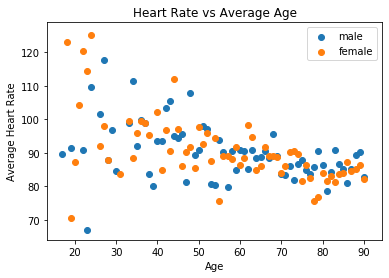

In [15]:
plot_HR_age(1, 'male')
plot_HR_age(0, 'female')
plt.show()

From our scatterplots, we can see that as the age increases, the average heart rate tends decrease as well.

Let's look more closely into our data, specifically focusing on the `In-hospital_death` outcome variable.

In [16]:
outcomes = []
for patient_data in ICU_data:
    outcomes.append(patient_data[feature_ind('In-hospital_death')] )

outcomes[:20] # the first 20 outcomes in the dataset
set(outcomes) # What are the outcomes that we observe
                     # in the dataset

{0.0, 1.0}

We can see that the `In-hospital_death` variable for each patient contains only one of two outcomes: 0 or 1. If the patient died in the ICU, the outcome is 1 and if the patient survived, the outcome is 0. 

Let's extract data only for patients who died in the ICU by searching for data for which `In-hospital_death` is equal to 1. 

In [17]:
patients_died = []
for patient_data in ICU_data:
    if patient_data[feature_ind('In-hospital_death')] == 1:
        patients_died.append(patient_data)

Let's see how many patients in our dataset died. 

In [18]:
len(patients_died)

554

Let's do the same thing for patients that did not die in the ICU. 

In [19]:
patients_lived = []
for patient_data in ICU_data:
    if patient_data[feature_ind('In-hospital_death')] == 0:
        patients_lived.append(patient_data)
        
len(patients_lived)

555

We see that the number of patients that survived and the number of patients that died in our dataset are roughly equal. (The data was prepared so that the numbers are roughly equal by selecting a subset of all the patients; the majority of ICU patients at Beth Israel Deaconess do not die). 

### 3. Training/Validation/Test Split 

We split our dataset into three separate sets: the training set, the validation set, and the test set. Each of the sets is used for a different purpose.

<img src="Train_Valid_Test.png" width="700">

**Training set:**  The input to the LM. The LM uses the training set to make the model. The LM uses patterns in the training set to make the model which tries to correctly predict the outcomes in the training set.

**Validation set:** The validation set is used to tune the model: we can try different model settings, and pick the settings which result in a model that makes the most accurate predictions for the data in the validation set.

**Test set:** This is the portion of our dataset that we use to evaluate how good the model will be at predicting outcomes for new data. The LM only "sees" the training set, and tries to make model's predictions match the outcomes in the training set. There is a danger that the model would work well on the training set, but not on new data. For that reason, we keep the test set separate from the training set -- the LM does not see the test set. We pretend the test set is new data, and compute the model's on it. This gives us an estimate for how well the model would predict the outcomes for new data.


By default, you should put 70% of the data in the training set, 15% of the data in the validation set, and 15% of the data in the test set.


Let's go ahead and generate our training, validation, and test sets from our `ICU_data`.

To generate our three datasets, we'll randomly assign 70% of our data to the training set, 15% of our data to the validation set, and the remaining 15% of our data to the test set. 



In [20]:
idx = list(range(len(ICU_data)))
np.random.shuffle(idx)

train_size = int(.7*len(ICU_data))
valid_size = int(.15*len(ICU_data)) 
test_size = int(.15*len(ICU_data))

train_dat = [ICU_data[i] for i in idx[:train_size]]
valid_dat = [ICU_data[i] for i in idx[train_size+1:train_size+valid_size+1]]
test_dat = [ICU_data[i] for i in idx[train_size+valid_size+2:train_size+valid_size+test_size+3]]

Let's check out the lengths of our datasets to make sure they are in line with our split ratios.

In [21]:
print('Number of patients in training set:', len(train_dat))
print('Number of patients in validation set:', len(valid_dat))
print('Number of patients in test set:', len(test_dat))

Number of patients in training set: 776
Number of patients in validation set: 166
Number of patients in test set: 165


The LM requires us to provide the predictor variables and the outcome separately. Here is a function that takes in a dataset and produces a list of lists containing the predictor variable data and a list of lists containing the outcome.

In [22]:
def get_x_y_split(data, predictors):
    """
    Split data into x and y components. 
    x will contain data corresponding to predictors of interest (specified in 'predictors' list).
    y will contain data corresponding to outcome variable ('In-hospital_death').
    
    Keyword arguments:
    data -- list of lists containing data 
    predictors -- list containing predictors of interest
    """    
    feats_inds = []
    x = []
    y = []

    for feature in predictors:
        feats_inds.append(feature_ind(feature))

    for patient_data in data:
        x.append([patient_data[i] for i in feats_inds])
        y.append(patient_data[feature_ind('In-hospital_death')])
    
    return x, y

Now we'll use the function above to divide up each of our datasets into predictor and outcome components. 

In [23]:
# The predictor variables to be used to predict the outcome
predictors = ['Age', 'Gender', 'HR', 'Height', 'PaCO2', 'PaO2', 'Temp', 'Weight']

train_dat_x, train_dat_y = get_x_y_split(train_dat, predictors)
valid_dat_x, valid_dat_y = get_x_y_split(valid_dat, predictors)
test_dat_x, test_dat_y = get_x_y_split(test_dat, predictors)

Let's use our `learning_machine` to now build our model using our training set consisting of `train_dat_x` and `train_dat_y` generated above. We'll name the output of our function `my_model`. 

In [24]:
my_model = lm.learning_machine(train_dat_x, train_dat_y, predictors)

#### What goes on inside the Learning Machine (LM)?

Let's get back to our Learning Machine.

The LM looks for patterns in the data in order to make a model. **Logistic regression** is one possible learning machine that is suitable for predicting outcomes that are either 0 or 1. The output of Logistic regression can be the prediction (an integer: 0 or 1) or it can be the probability that the outcome is 1 (a probability is a real number between 0 and 1). If the output close to 1, the LM believes the outcome to be 1.

In our ICU example, we are predicting whether the patient will die the ICU. Recall that 0 corresponds to "Survived" and 1 corresponds to "Died".

### 3. The Predict Function

Now that our LM has generated a model for us after having learned the relationships in the data, we want to use our model to make predictions, given new data. Recall that since our LM only learned patterns from our training set, our validation set and test set can both constitute new data.

<img src="Predict.png" width="600">

We will now use the `predict` function, which takes in our model and new data as inputs. The output of the function will be a value between 0 and 1, representing the probability that the model believes the outcome will be 1. Let's go ahead and use `my_model` produced by the learning machine to make predictions, given our validation set. We'll assign the output of our `predict` function to `predictions`.

In [25]:
predictions = lm.predict(my_model, valid_dat_x)

Here is the prediction for the 11-th patient:

In [26]:
predictions[10]

0.48997597666217585

### 4. Correct Classification Rate

After having made predictions using `predict`, we want to know how accurate our model was. To evaluate our model's performance, we can calculate what is called a correct classification rate (CCR) using the function `getCCR`. The CCR is computed by counting the number of correctly classified outcomes (correctly predicted a patient will die or correctly predicted a patient will survive) and dividing this number by the total number of predictions made. 

Let's build a function called `getCCR` to get this done.

In [27]:
def getCCR(model, x_data, y_data):
    """
    Compute correct classification rate.
    
    Keyword arguments:
    x_data -- list of lists containing predictors 
    y_data -- list of lists containing outcome   
    model -- model generated by the learning machine
    """
    correctly_classified = 0

    for i, outcome in enumerate(y_data):
        pred = lm.predict(model, x_data)[i] > 0.5
        if pred == outcome:
            correctly_classified += 1
    
    return correctly_classified/len(y_data)

Let's check out our model's performance on the validation set.

In [28]:
getCCR(my_model, valid_dat_x, valid_dat_y)

0.6385542168674698

It looks like around 64.5% of the model's predictions were correct (on the validation set -- you can compute the CCR on the training set, but it's not as interesting; it is not impressive if a model can correctly predict the outcomes for patients the model has been trained with.) We observe performance that is higher than 50%. This is better than tossing a fair coin. That means that the model predicts something meaningful. (Note that if, for example, 90% of patients survived and 10% died, a 65% CCR would be very unimpressive -- we could do better by simply predicting "survived" for every patient. But in our dataset, where about 50% of the patients survived and 50% died, a 65% CCR means the model can be useful. The proportion of the plurality outcome is called the *base rate*).

Let's make a function that computes the base rate.



In [29]:
def getBaseRate(y_data):
    """
    Compute base rate.

    Keyword arguments:
    y_data -- list of lists containing outcome    
    """
    return sum(y_data) / len(y_data)

Let's find the base rate for our validation set.

In [30]:
getBaseRate(valid_dat_y)

0.5421686746987951

We see that our model's performance is around 10.2% higher than the base rate. The smaller this difference (the closer our CCR is to the base rate), the worse our model is at making predictions. 



#### More on Logistic Regression (optional)

Logistic regression computes a "rating" for each patient in the dataset. The larger the rating, the larger the probability of the outcome's being 1 according to the logistic regression.

In our model, we will use following as predictors: `Age`, `Gender`, `HR`, `Height`, `PaCO2`, `PaO2`, `Temp`, and `Weight`. We will also need our outcome variable: `In-hospital_death`. The rating is computed as follows.  

$$Rating = \beta_0 + \beta_1Age + \beta_2Gender + \beta_3HR + \beta_4Height + \beta_5PaCO_2 + \beta_6PaO_2 + \beta_7Temp + \beta_8Weight$$

Each predictor variable is multiplied by different coefficients represented by $\beta$s. If the LM thinks that a certain predictor is more predictive of the outcome, it will assign a higher coefficient to it, effectively giving it more weight in our model.

Before we start building our model based on the `ICU_data`, we'll walk through splitting our dataset into the training set, validation set, and test set.

`model.coefs` will show us the model's coefficients. Recall from earlier in this tutorial that the logistic regression algorithm calculates a rating based on a weighted sum. Each predictor is weighted by a certain coefficient that indicates the predictive degree of the predictor.

In [31]:
my_model.coefs

[('Age', 0.03298076267856131),
 ('Gender', 0.1609301160957725),
 ('HR', 0.02569835964092494),
 ('Height', -0.008967682024184341),
 ('PaCO2', -0.03112803398475024),
 ('PaO2', -0.004118490319768773),
 ('Temp', -0.03748239631997881),
 ('Weight', -0.00011714197817034553)]

A positive coefficient means the model believes there is a positive correlation between the feature and an outcome of 1 (dying in the ICU). A negative coefficient means the model believes there is a negative correlation between the feature and an outcome of 1. Note that we cannot directly compare the coefficients assigned to the various features because they have not been normalized. *Normalization* is a technique used in data preparation to change the values of variables to a common scale so that they could be compared. We will skip this process in this tutorial for the sake of simplicity. For now, what we can say is how each predictor seems to be affecting model's prediction. For example, from the coefficients generated above, we can say that an increase in 'Age' of 1 year would increase the score (weighted sum) by about 0.0335, making it more likely for the model to predict that the patient will die.